In [16]:
# Yale Shiller Data:  http://www.econ.yale.edu/~shiller/data.html
options(warn=-1)
  
library(readxl)
library(zoo)

temp <- paste0(tempfile(),".xls") # Has to match download extention
download.file("http://www.econ.yale.edu/~shiller/data/ie_data.xls", destfile = temp, mode="wb")
data <- read_excel(temp, sheet = 3, col_names = F)
unlink(temp)

namesData <- c("Date", "S&P_Comp.P", "Dividend", "Earnings", "CPI", "Date_Fraction", "Long_Interest", "Real_Price","Real_Dividend", "Real_Earnings", "Cycl_Adj_CAPE")

data <- data[9:length(data[,1]),] # Trim top
data <- data[1:length(data[,1][!is.na(data[,1])]),] # Trim bottom
names(data) <- namesData

splitFrame = c()
for (i in 1:length(data[,1])){
  splitFrame <- strsplit(as.character(gsub('.{4}$', '', data[,1][i])), "\\.")
  data[,1][i] <- paste0(splitFrame[[1]][2],"/","15","/", splitFrame[[1]][1])   
}

# data[,1] <- as.yearmon(format( date_decimal( as.numeric(data[,1]) ), "%m-%Y"), "%m-%Y")
data[,1] <- zoo::as.yearmon(as.Date(data[,1],"%m/%d/%Y"))

# Convert to numeric
data[,2:11] <- sapply(data[,2:11],as.numeric)

# Creates leading value to compare with CAPE
Yr10Forward <- diff(data$'S&P_Comp.P', lag = 120) # Ten year leading
Yr10Forward <- exp(log(Yr10Forward/(data$'S&P_Comp.P'[1:length(Yr10Forward)])+1)/10) -1 
Yr10Forward <- c(Yr10Forward, rep(NA, 120))
data <- cbind(data, Yr10Forward)


DEFINEDNAME: 00 00 00 0f 03 00 00 00 00 00 00 00 00 00 00 5f 52 65 67 72 65 73 73 69 6f 6e 5f 49 6e 74 1e 01 00 
DEFINEDNAME: 20 00 00 01 0b 00 00 00 00 00 00 00 00 00 00 06 3b 00 00 09 06 14 06 00 00 0b 00 
DEFINEDNAME: 00 00 00 0d 0b 00 00 00 00 00 00 00 00 00 00 50 72 69 6e 74 5f 41 72 65 61 5f 4d 49 3b 00 00 09 06 14 06 00 00 0b 00 
DEFINEDNAME: 00 00 00 0f 03 00 00 00 00 00 00 00 00 00 00 5f 52 65 67 72 65 73 73 69 6f 6e 5f 49 6e 74 1e 01 00 
DEFINEDNAME: 20 00 00 01 0b 00 00 00 00 00 00 00 00 00 00 06 3b 00 00 09 06 14 06 00 00 0b 00 
DEFINEDNAME: 00 00 00 0d 0b 00 00 00 00 00 00 00 00 00 00 50 72 69 6e 74 5f 41 72 65 61 5f 4d 49 3b 00 00 09 06 14 06 00 00 0b 00 
DEFINEDNAME: 00 00 00 0f 03 00 00 00 00 00 00 00 00 00 00 5f 52 65 67 72 65 73 73 69 6f 6e 5f 49 6e 74 1e 01 00 
DEFINEDNAME: 20 00 00 01 0b 00 00 00 00 00 00 00 00 00 00 06 3b 00 00 09 06 14 06 00 00 0b 00 
DEFINEDNAME: 00 00 00 0d 0b 00 00 00 00 00 00 00 00 00 00 50 72 69 6e 74 5f 41 72 65 61 5f 4d 49 3b 00 00 09 06 14

In [11]:
head(data)

,Date,S&P_Comp.P,Dividend,Earnings,CPI,Date_Fraction,Long_Interest,Real_Price,Real_Dividend,Real_Earnings,Cycl_Adj_CAPE,Yr10Forward
9,Jan 1871,4.44,0.26,0.4,12.46406,1871,5.32,85.5,5,7.7,NA,0.03378629
10,Feb 1871,4.5,0.26,0.4,12.84464,1871.1,5.3,84.1,4.9,7.5,NA,0.03206551
11,Mar 1871,4.61,0.26,0.4,13.03497,1871.2,5.3,84.9,4.8,7.4,NA,0.03073819
12,Apr 1871,4.74,0.26,0.4,12.55923,1871.3,5.3,90.6,5,7.6,NA,0.02754584
13,May 1871,4.86,0.26,0.4,12.27381,1871.4,5.3,95.1,5.1,7.8,NA,0.02950322
14,Jun 1871,4.82,0.26,0.4,12.08348,1871.5,5.3,95.8,5.2,7.9,NA,0.03161556


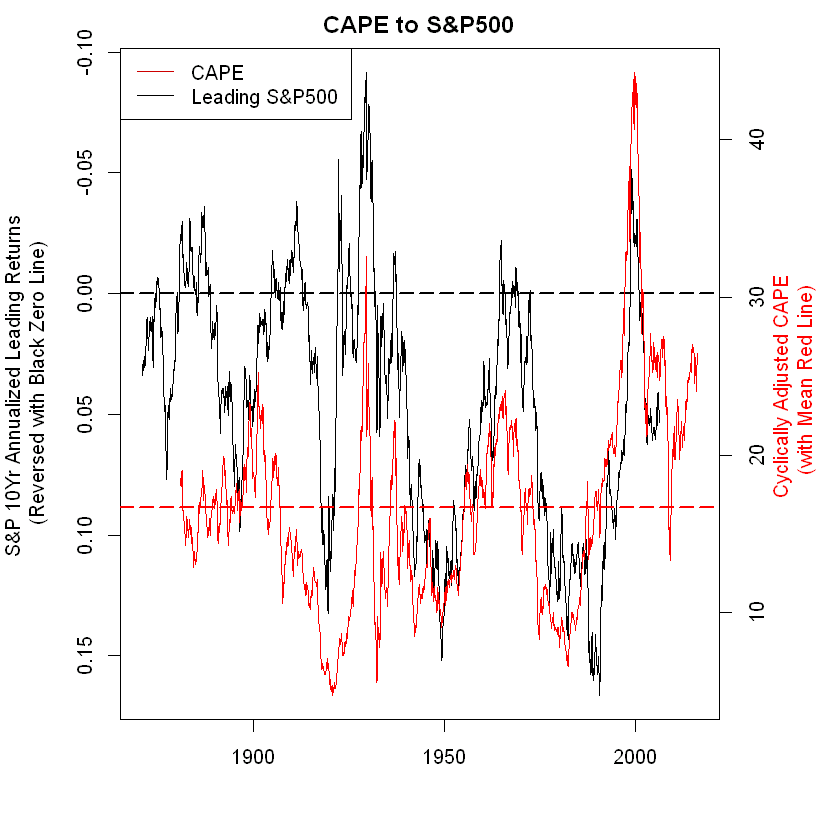

In [7]:
par(mar = c(5,5,2,5))
with(data, plot(data$Date, data$'Yr10Forward', main = "CAPE to S&P500", 
                ylim = rev(range(data$'Yr10Forward',na.rm = T)), type="l", col="black",
                xlab = NA, ylab = 'S&P 10Yr Annualized Leading Returns \n(Reversed with Black Zero Line)'))
abline(h = 0, col = "black", lty = 5, lwd = 2)
par(new = T)
with(data, plot(data$Date, data$'Cycl_Adj_CAPE', type = "l", col = 'red', pch = 19, axes=F, xlab=NA, ylab=NA, cex=1.3))
abline(h = mean(data$'Cycl_Adj_CAPE', na.rm = T), col = "red", lty = 5, lwd = 2)
axis(side = 4)
mtext(side = 4, line = 3, "Cyclically Adjusted CAPE \n (with Mean Red Line)", col = 'red')
legend("topleft",
       legend=c("CAPE", "Leading S&P500"),
       lty=c(1,1), col=c("red3", "black"))


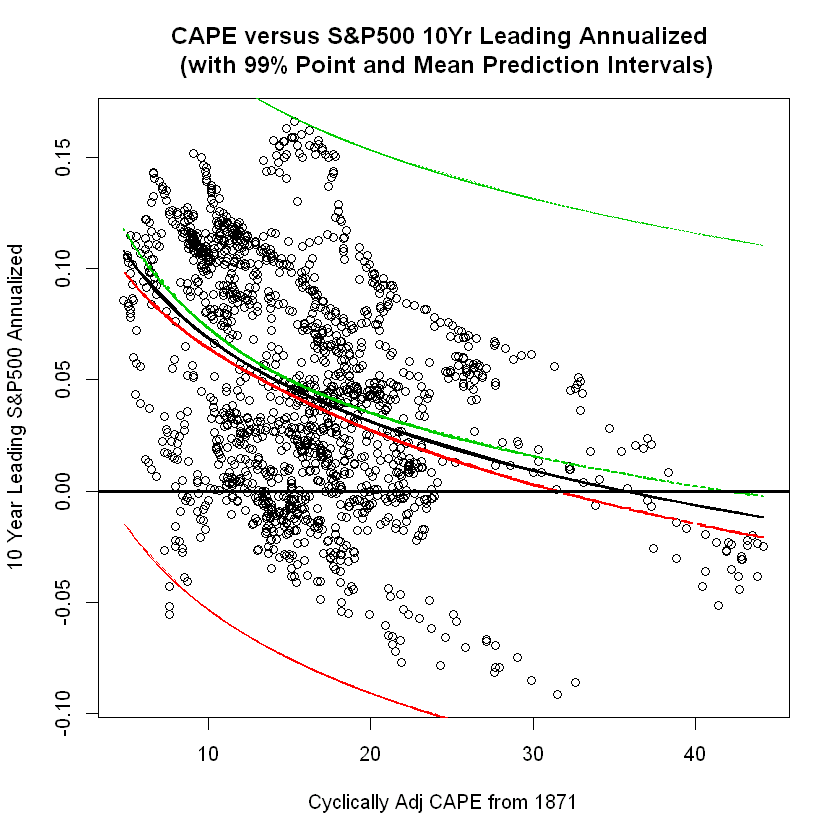

In [26]:
# Log Regression with Point and Mean Prediction Intervals
dataReg <- lm(data$'Yr10Forward' ~ log(data$'Cycl_Adj_CAPE') )
x = data$'Yr10Forward'
plot(data$'Cycl_Adj_CAPE', data$'Yr10Forward', ylab = "10 Year Leading S&P500 Annualized", xlab = "Cyclically Adj CAPE from 1871", main = "CAPE versus S&P500 10Yr Leading Annualized \n (with 99% Point and Mean Prediction Intervals)")
y = predict(dataReg, newdata=list(data.frame(data$'Cycl_Adj_CAPE')), interval="confidence", level = 0.99)
matlines(data.frame(data$'Cycl_Adj_CAPE'), y, lwd = 2)
z = predict(dataReg, newdata=list(data.frame(data$'Cycl_Adj_CAPE')), interval="prediction", level = 0.99)
matlines(data.frame(data$'Cycl_Adj_CAPE'), z,lwd = 1)
abline(h = 0, pch = 3, lwd = "3")

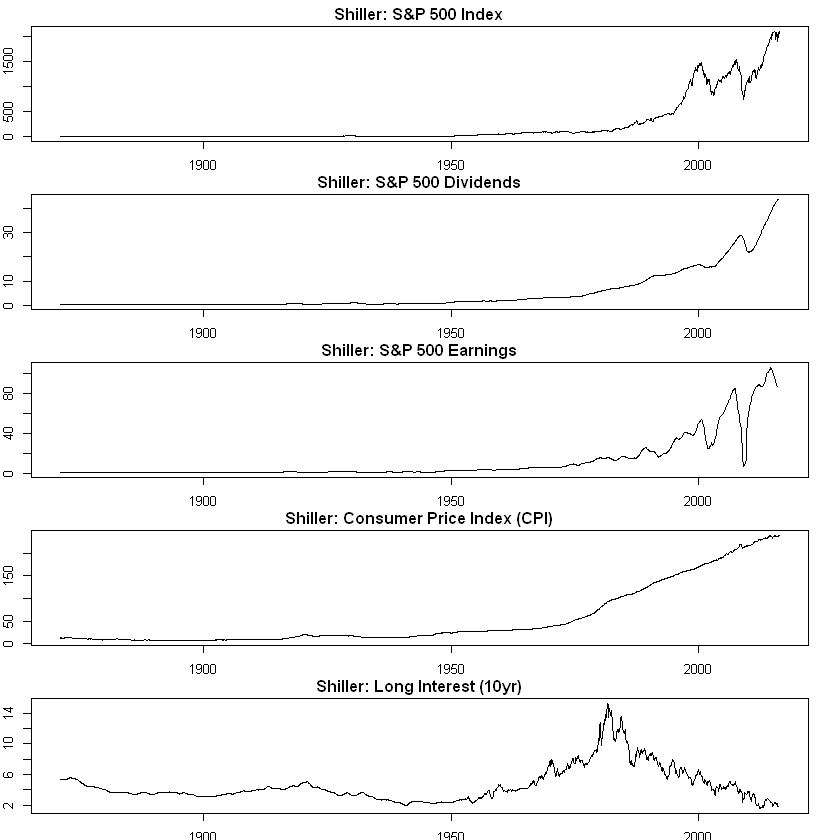

In [8]:
par(mfrow=c(5,1),mar=c(1.7,2,1.7,2))
plot( data$Date, data$"S&P_Comp.P" , type = "l",
      xlab = "", ylab = "", main = "Shiller: S&P 500 Index")
plot( data$Date, data$"Dividend"  , type = "l",
      xlab = "", ylab = "", main = "Shiller: S&P 500 Dividends")
plot( data$Date, data$"Earnings"  , type = "l",
      xlab = "", ylab = "", main = "Shiller: S&P 500 Earnings")
plot( data$Date, data$"CPI"  , type = "l",
      xlab = "", ylab = "", main = "Shiller: Consumer Price Index (CPI)")
plot( data$Date, data$"Long_Interest"  , type = "l",
      xlab = "", ylab = "", main = "Shiller: Long Interest (10yr)")

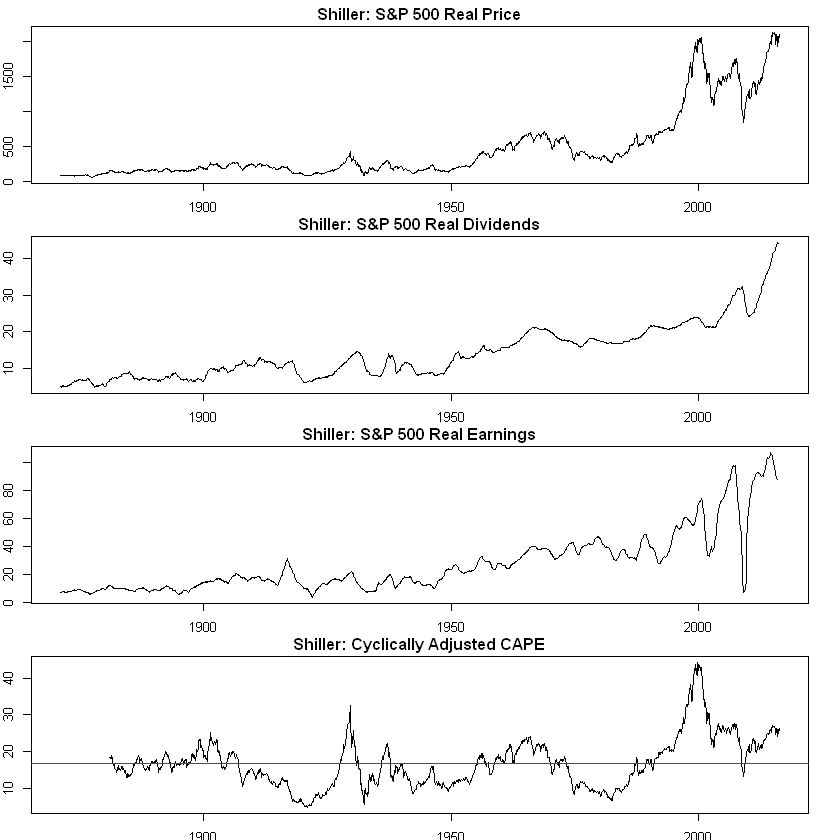

In [9]:
par(mfrow=c(4,1),mar=c(1.7,2,1.7,2))
plot( data$Date, data$"Real_Price" , type = "l",
      xlab = "", ylab = "", main = "Shiller: S&P 500 Real Price")
plot( data$Date, data$"Real_Dividend"  , type = "l",
      xlab = "", ylab = "", main = "Shiller: S&P 500 Real Dividends")
plot( data$Date, data$"Real_Earnings"  , type = "l",
      xlab = "", ylab = "", main = "Shiller: S&P 500 Real Earnings")
plot( data$Date, data$"Cycl_Adj_CAPE"  , type = "l",
      xlab = "", ylab = "", main = "Shiller: Cyclically Adjusted CAPE")
abline(h=mean(data$"Cycl_Adj_CAPE", na.rm=T), col="red")